# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 203972922 201312907

In [1]:
import numpy as np
np.random.seed(42)  # added by roy
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
# First, lets understand the data

In [5]:
training_set.shape

(2000, 3)

In [6]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   y       2000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 47.0 KB


In [7]:
training_set.describe(include='all')

,x1,x2,y
count,2000.000000,2000.000000,2000.00000
mean,0.844608,5.864061,0.40000
std,4.051899,2.593666,0.49002
min,-7.659203,-1.219830,0.00000
25%,-2.897422,4.160386,0.00000
50%,1.251215,5.859231,0.00000
75%,4.565506,7.664301,1.00000
max,8.612389,13.614355,1.00000


In [8]:
training_set['y'].value_counts()

0    1200
1     800
Name: y, dtype: int64

In [9]:
X_training.shape

(2000, 2)

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [10]:
# preparations
training_subset_1000 = training_set.head(1000)
first_feature_y_equals_0 = training_subset_1000[training_set['y']==0]['x1'].values
first_feature_y_equals_1 = training_subset_1000[training_set['y']==1]['x1'].values

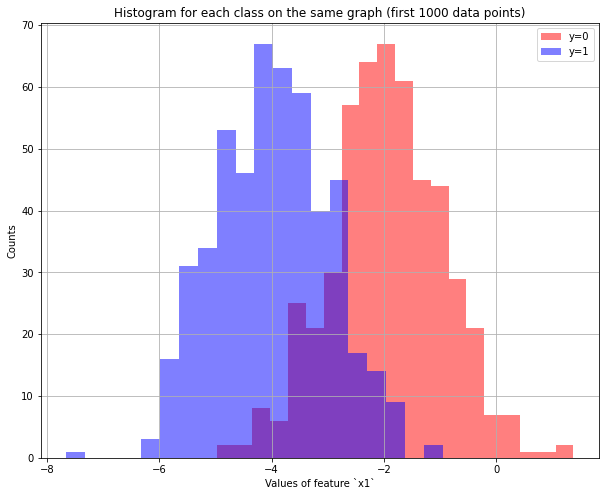

In [11]:
plt.figure()
plt.hist(first_feature_y_equals_0[0:1000], bins=20, alpha=0.5, color='r', label='y=0')
plt.hist(first_feature_y_equals_1[0:1000], bins=20, alpha=0.5, color='b', label='y=1')
plt.title(f'Histogram for each class on the same graph (first 1000 data points)')
plt.xlabel(f'Values of feature `x1`')
plt.ylabel(f'Counts')
plt.grid()
plt.legend()
plt.show()

In [12]:
# preparations
first_feature_y_equals_0 = training_set[training_set['y']==0]['x1'].values
first_feature_y_equals_1 = training_set[training_set['y']==1]['x1'].values

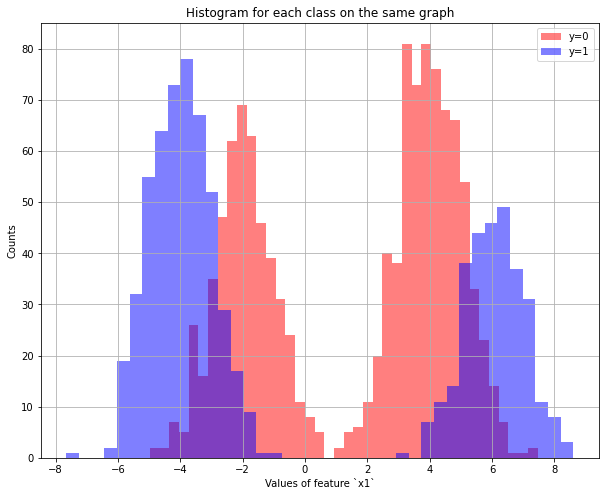

In [13]:
plt.figure()
plt.hist(first_feature_y_equals_0, bins=40, alpha=0.5, color='r', label='y=0')
plt.hist(first_feature_y_equals_1, bins=40, alpha=0.5, color='b', label='y=1')
plt.title(f'Histogram for each class on the same graph')
plt.xlabel(f'Values of feature `x1`')
plt.ylabel(f'Counts')
plt.grid()
plt.legend()
plt.show()

In [14]:
# preparations
feature_x1_where_y_equals_0 = training_subset_1000[training_set['y']==0]['x1'].values
feature_x1_where_y_equals_1 = training_subset_1000[training_set['y']==1]['x1'].values
feature_x2_where_y_equals_0 = training_subset_1000[training_set['y']==0]['x2'].values
feature_x2_where_y_equals_1 = training_subset_1000[training_set['y']==1]['x2'].values

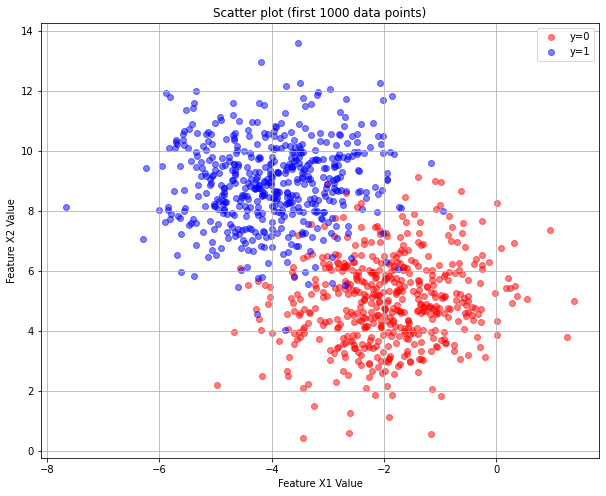

In [15]:
plt.figure()
plt.scatter(x=feature_x1_where_y_equals_0[0:1000],
            y=feature_x2_where_y_equals_0[0:1000], 
            alpha=0.5, color='r', label='y=0')
plt.scatter(x=feature_x1_where_y_equals_1[0:1000], 
            y=feature_x2_where_y_equals_1[0:1000],
            alpha=0.5, color='b', label='y=1')
plt.title(f'Scatter plot (first 1000 data points)')
plt.xlabel(f'Feature X1 Value')
plt.ylabel(f'Feature X2 Value')
plt.grid()
plt.legend()
plt.show()

In [16]:
# preparations
feature_x1_where_y_equals_0 = training_set[training_set['y']==0]['x1'].values
feature_x1_where_y_equals_1 = training_set[training_set['y']==1]['x1'].values
feature_x2_where_y_equals_0 = training_set[training_set['y']==0]['x2'].values
feature_x2_where_y_equals_1 = training_set[training_set['y']==1]['x2'].values

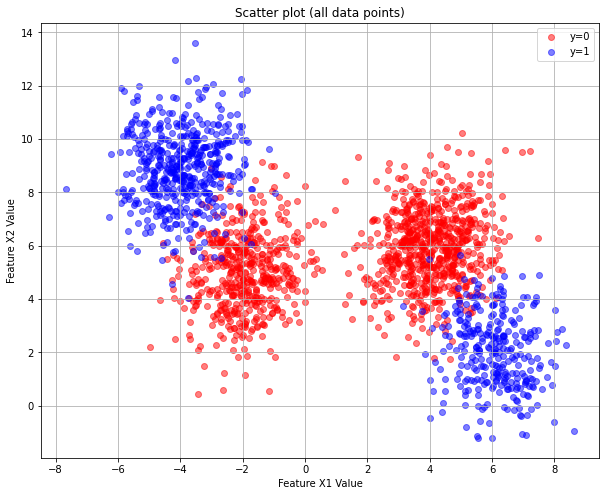

In [17]:
plt.figure()
plt.scatter(x=feature_x1_where_y_equals_0,
            y=feature_x2_where_y_equals_0, 
            alpha=0.5, color='r', label='y=0')
plt.scatter(x=feature_x1_where_y_equals_1, 
            y=feature_x2_where_y_equals_1,
            alpha=0.5, color='b', label='y=1')
plt.title(f'Scatter plot (all data points)')
plt.xlabel(f'Feature X1 Value')
plt.ylabel(f'Feature X2 Value')
plt.grid()
plt.legend()
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [19]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self._eta = eta
        self._n_iter = n_iter
        self._eps = eps
        self._random_state = random_state
        
        # init others
        self._list_of_costs = []
        self._threshold = 0.5
        
    def _compute_cost(self, X, y):
        y_preds = np.matmul(X, self._theta)   #previously # y_preds = [np.matmul(self._theta.T, X[i,:]) for i in range(m)] 
        
        left_term = np.matmul(y, np.log(sigmoid(y_preds))) 
        right_term = np.matmul((1-y), np.log(1 - sigmoid(y_preds)))
        combined_term = left_term + right_term
        
        # get the final calculation of cost over all samples
        final = - np.mean(combined_term)  
        
        return final
    
    def _compute_gradient_descent_step(self, X, y):
        # init
        deltas = np.zeros_like(self._theta)        
        
        # calc
        y_preds = sigmoid(np.matmul(X, self._theta))
        deltas = np.matmul(y_preds-y, X)
        
        # step
        new_theta = self._theta - self._eta * deltas   
        return new_theta
    
    def get_theta(self):
        return self._theta
    
    def get_list_of_costs(self):
        return self._list_of_costs

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
            
        # Bias trick
        num_of_features = X.shape[1] + 1
        num_of_samples = X.shape[0]
        X = np.concatenate((np.ones(num_of_samples).reshape(-1,1), X), axis=1)
        
        # Create theta vector
        self._theta = np.random.uniform(low=0.0, high=1.0, size=(num_of_features,))
                
        # iterate
        for iteration in range(self._n_iter):
            # Compute current cost
            curr_cost = self._compute_cost(X, y)
            curr_theta = self._compute_gradient_descent_step(X, y)
            
            # Update parameters
            self._list_of_costs.append(curr_cost)
            self._theta = curr_theta
            
            # Check stop condition
            difference = 10000 if len(self._list_of_costs) <= 1 else np.abs(self._list_of_costs[-1] - self._list_of_costs[-2])
            if difference < self._eps:
                # print(f'reached early stop condition at iteration {iteration}')
                break
            
    def predict(self, X):
        """Return the predicted class label"""
        # Bias trick
        num_of_samples = X.shape[0]
        X = np.concatenate((np.ones(num_of_samples).reshape(-1,1), X), axis=1)
        
        # Predict
        y_preds = np.matmul(X, self._theta)   # size mismatch:  np.matmul(self._theta, X)   
        y_preds = [sigmoid(y_pred) for y_pred in y_preds]
        y_preds = [1 if value > self._threshold else 0 for value in y_preds]
                
        return np.array(y_preds)

In [20]:
## Testing LR class !
# test init
model = LogisticRegressionGD(eta=0.1, n_iter=10000, eps=0.1, random_state=1)
# test fit
model.fit(X_training, y_training)
# test prediction
y_pred = model.predict(X_training)

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [21]:
#  CV hyperparams !
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]    # original: [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]    # original: [0.01, 0.001, 0.0001, 0.00001, 0.000001]
num_iterations = 10000                             # original:  10000 
num_of_folds = 5                                   # original:  5

In [22]:
def compute_accuracy(y_true, y_pred):
    assert len(y_pred) == len(y_true)
    accuracy = (y_pred == y_true).mean()
    return accuracy

In [23]:
def grid_search_cv(X, y, num_of_folds, etas, epss, n_iter = 10000):
    best_eta = 0
    best_eps = 0
    best_accuracy = 0
    
    # init assisting params
    num_of_samples = X.shape[0]
    val_fold_size = num_of_samples // num_of_folds
    all_indices = np.arange(num_of_samples)

    # organize the data
    new_data = np.concatenate((X, y.reshape(-1,1)), axis=1)
    np.random.shuffle(new_data)  #shuffles rows of X
    folds = [np.arange((num) * val_fold_size, (num+1) * val_fold_size,1) for num in range(num_of_folds)]
    
    # iterate
    for eta in etas:
        for eps in epss:
            print(f'\n**********\nPerforming new CV. Testing params: eta {eta} eps {eps}')
            accuracies = []
            for iteration, fold in enumerate(folds):                
                # unpack
                val_indices = fold
                all_other_indices = set(all_indices) ^ set(fold)
                train_indices = np.array(list(all_other_indices))

                curr_X_train = new_data[train_indices,0:-1]
                curr_y_train = new_data[train_indices,-1]
                curr_X_val = new_data[val_indices,0:-1]
                curr_y_val = new_data[val_indices,-1]
                
                model = LogisticRegressionGD(eta=eta, eps=eps, n_iter=n_iter) 
                model.fit(curr_X_train, curr_y_train)
                y_pred = model.predict(curr_X_val)
                curr_accuracy = compute_accuracy(y_true=curr_y_val, y_pred=y_pred)
                accuracies.append(curr_accuracy)
            
            final_accuracy = np.mean(accuracies)
            if final_accuracy > best_accuracy:
                best_eta = eta
                best_eps = eps
                best_accuracy = final_accuracy
                print(f'\o/ **** improved best ! with: eta {best_eta} eps {best_eps} acc: {best_accuracy} ****')
   
    print(f'\n**********\nBest params are: eta {best_eta} eps {best_eps} acc: {best_accuracy}')
    return best_eta, best_eps

In [24]:
%%time
best_eta, best_eps = grid_search_cv(X=X_training, y=y_training, num_of_folds=num_of_folds, etas=etas, epss=epss, n_iter=num_iterations)


**********
Performing new CV. Testing params: eta 0.05 eps 0.01
\o/ **** improved best ! with: eta 0.05 eps 0.01 acc: 0.43999999999999995 ****

**********
Performing new CV. Testing params: eta 0.05 eps 0.001
\o/ **** improved best ! with: eta 0.05 eps 0.001 acc: 0.5315000000000001 ****

**********
Performing new CV. Testing params: eta 0.05 eps 0.0001
\o/ **** improved best ! with: eta 0.05 eps 0.0001 acc: 0.5625 ****

**********
Performing new CV. Testing params: eta 0.05 eps 1e-05

**********
Performing new CV. Testing params: eta 0.05 eps 1e-06

**********
Performing new CV. Testing params: eta 0.005 eps 0.01
\o/ **** improved best ! with: eta 0.005 eps 0.01 acc: 0.599 ****

**********
Performing new CV. Testing params: eta 0.005 eps 0.001

**********
Performing new CV. Testing params: eta 0.005 eps 0.0001

**********
Performing new CV. Testing params: eta 0.005 eps 1e-05

**********
Performing new CV. Testing params: eta 0.005 eps 1e-06

**********
Performing new CV. Testing para

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [25]:
# assumption: data has only one feature. or else, the formula above would be different, suitable for multi features case
def norm_pdf(data, mu, sigma):
    const_argument = 1 / (sigma * np.sqrt(2 * np.pi))
    exp_argument = np.exp(- (data - mu) ** 2 / (2 * sigma ** 2))
    return const_argument * exp_argument

In [26]:
# ## TEST : verify above function
# import scipy
# arr = np.array([1,2,3,4,5])
# pdf = scipy.stats.norm(loc=1, scale=1)
# res1 = pdf.pdf(arr)
# res2 = norm_pdf(data=arr, mu=1, sigma=1)
# # print(f'pdf.pdf(arr) {res1}')
# # print(f'norm_pdf(data=arr, mu=1, sigma=1) {res2}')

# assert all([True if res1[i] == res2[i] else False for i in range(len(arr))])

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [27]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):        
        self._num_of_gausians = k
        self._n_iter = n_iter
        self._eps = eps
        self._list_of_costs = []
    
    def get_list_of_costs(self):
        return self._list_of_costs
    
    def _compute_cost(self, X):
        """ assumption: X is of size (num of samples , 1) """
        # prepare temp calculation var
        results = np.zeros(self._num_of_gausians)
        
        # iterate over gausians and calculate cost per gausian
        for k in range(self._num_of_gausians):        
            # unpack
            w = self._weights[k]
            mu = self._means[k]
            sig = self._stds[k]
            
            #
            curr_minus_np_log = -np.log(w * norm_pdf(data=X, mu=mu, sigma=sig))
            assert curr_minus_np_log.shape[0] == X.shape[0]
            
            # sum results of this gausian
            results[k] = np.sum(curr_minus_np_log).squeeze()

        final = np.mean(results)  #V.
        return final

    def init_params(self, data):
        """
        Initialize distribution params
        """
        # Assumption: "data" is a numpy 2d matrix
        self._means = np.ones(self._num_of_gausians) * np.mean(data) #smart init instead of random 
        self._stds = np.ones(self._num_of_gausians) * np.std(data)   #smart init instead of random 
        self._weights = np.ones(self._num_of_gausians) / self._num_of_gausians
        self._responsibilities = np.zeros((data.shape[0], self._num_of_gausians))

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        # prepare 
        X = data
        results = []
        
        # iterate
        for k in range(self._num_of_gausians):        
            # unpack
            w = self._weights[k]
            mu = self._means[k]
            sig = self._stds[k]
            
            # calc
            curr = w * norm_pdf(data=X, mu=mu, sigma=sig)
            
            # append this result to be later concatanated into responsibilities matrix
            results.append(curr.reshape(-1,1))
        
        self._responsibilities = np.concatenate(results, axis=1)
        
        denominator = np.sum(self._responsibilities, axis=1)
        assert denominator.shape[0] == X.shape[0]
        
        for k in range(self._num_of_gausians): 
            self._responsibilities[:,k] = np.divide(self._responsibilities[:, k], denominator)
            
        ### other version: ###
        # for i, x in enumerate(X):              
            # for k in range(self._num_of_gausians):
                # numerator = self._weights[k] * norm_pdf(data=x, mu=self._means[k], sigma=self._stds[k])
                # denominator_list = [self._weights[k] * norm_pdf(data=x, mu=self._means[j], sigma=self._stds[j]) for j in range(self._num_of_gausians)]
                # self._responsibilities[i, k] = numerator / sum(denominator_list)
                
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        # prepare
        X = data
        N = len(X)
        
        # new weights
        self._weights = np.mean(self._responsibilities, axis=0)  # mean across columns !!?!?

        # new means
        for j in range(len(self._weights)):
            numerator_list = [self._responsibilities[i, j] * X[i] for i in range(N)]
            denominator = self._weights[j] * N
            self._means[j] = np.sum(numerator_list) / denominator
        
        # new stds
        for j in range(len(self._weights)):
            numerator_list = [self._responsibilities[i, j] * (X[i] - self._means[j])**2 for i in range(N)]
            denominator = self._weights[j] * N
            self._stds[j] = np.sqrt(np.sum(numerator_list) / denominator)
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """        
        # initialize relevant parameters
        self.init_params(data)
        
        # iterate
        for iteration in range(self._n_iter):
            
            # perform E->M
            self.expectation(data)
            self.maximization(data)
            
            # Compute current cost
            curr_cost = self._compute_cost(X=data)
            
            # Update parameters
            self._list_of_costs.append(curr_cost)            
            
            # Check stop condition
            difference = 10000 if len(self._list_of_costs) <= 1 else np.abs(self._list_of_costs[-1] - self._list_of_costs[-2])
            if difference < self._eps:
                # print(f'reached early stop condition at iteration {iteration}')
                break

    def get_dist_params(self):
        return [ (weight, mu, sigma) for weight, mu, sigma in zip(self._weights, self._means, self._stds)]
    

In [28]:
%%time
### TEST EM !
dat = np.concatenate((X_training.copy(), y_training.copy().reshape(-1,1)), axis=1)
np.random.shuffle(dat)  #shuffles rows of X
temp_X = dat[990:1010, 0:-1]
temp_y = dat[990:1010, -1]
# test init
em_feature1 = EM(k=3, n_iter=3)
# test fit
em_feature1.fit(temp_X[:,0])
# test get_dist_params
em_feature1.get_dist_params()

CPU times: user 4.57 ms, sys: 2.04 ms, total: 6.61 ms
Wall time: 5.07 ms


[(0.33333333333333326, 0.8844912190892068, 3.894828685087463),
 (0.33333333333333326, 0.8844912190892068, 3.894828685087463),
 (0.33333333333333326, 0.8844912190892068, 3.894828685087463)]

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [29]:
class GMM(object):
    def __init__(self, num_of_gausians: int, params: list):
        assert num_of_gausians == len(params)
        self._num_of_gausians = num_of_gausians
        self._params = params
            
    def pdf(self, X):
        """
        assumpotion: X is size (num samples, 1) meaning X has only one feature
        """
        if isinstance(X, np.ndarray) or isinstance(X, list):            
            list_of_weighted_norms = [weight * norm_pdf(data=X, mu=mean, sigma=std).reshape(-1,1) for (weight, mean, std) in self._params]
            concat = np.concatenate(list_of_weighted_norms, axis=1)
            results = np.sum(concat, axis=1).squeeze()            
            assert results.shape[0] == X.shape[0]
        
        else:
            # assuming that X is a float or int
            list_of_weighted_norms = [weight * norm_pdf(data=X, mu=mean, sigma=std) for (weight, mean, std) in self._params]            
            results = np.sum(list_of_weighted_norms)

        return results

In [30]:
%%time
#### TEST GMM !
# test init
gmm = GMM(num_of_gausians=2, params = [(0.5,1,1),(0.5,2,2)])
# test pdf
gmm.pdf(5)
gmm.pdf(np.array([1,2,3,4,5]))

CPU times: user 264 µs, sys: 42 µs, total: 306 µs
Wall time: 291 µs


array([0.28748747, 0.22072093, 0.11501181, 0.06270861, 0.03244631])

In [31]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        # save args from outside        
        self._num_of_gausians = k
        
        # init EM classes 
        self._EM_feautre_1_label_0 = EM(k=k)
        self._EM_feautre_1_label_1 = EM(k=k)
        self._EM_feautre_2_label_0 = EM(k=k)
        self._EM_feautre_2_label_1 = EM(k=k)
        
        # save additional params
        self._prior_label_0 = None
        self._prior_label_1 = None

        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        indices_y_equals_0 = np.where(y == 0)[0]
        indices_y_equals_1 = np.where(y == 1)[0]
        
        # get priors
        self._prior_label_0 = len(indices_y_equals_0) / len(y)
        self._prior_label_1 = len(indices_y_equals_1) / len(y)
        
        # fit the EMs
        self._EM_feautre_1_label_0.fit(data=X[indices_y_equals_0, 0])
        self._EM_feautre_1_label_1.fit(data=X[indices_y_equals_1, 0])
        self._EM_feautre_2_label_0.fit(data=X[indices_y_equals_0, 1])
        self._EM_feautre_2_label_1.fit(data=X[indices_y_equals_1, 1])
        
        # get params for the GMMs
        self._feautre_1_label_0_params = self._EM_feautre_1_label_0.get_dist_params()
        self._feautre_1_label_1_params = self._EM_feautre_1_label_1.get_dist_params()
        self._feautre_2_label_0_params = self._EM_feautre_2_label_0.get_dist_params()
        self._feautre_2_label_1_params = self._EM_feautre_2_label_1.get_dist_params()
        
        # init the GMMs
        self._GMM_feautre_1_label_0 = GMM(self._num_of_gausians, self._feautre_1_label_0_params)
        self._GMM_feautre_1_label_1 = GMM(self._num_of_gausians, self._feautre_1_label_1_params)
        self._GMM_feautre_2_label_0 = GMM(self._num_of_gausians, self._feautre_2_label_0_params)
        self._GMM_feautre_2_label_1 = GMM(self._num_of_gausians, self._feautre_2_label_1_params)
        
    
    def predict(self, X):
        """Return the predicted class label"""
                        
        results = np.zeros(X.shape[0])
        y_preds = np.zeros(X.shape[0])
                
        label_0_likelihoods = np.multiply(self._GMM_feautre_1_label_0.pdf(X[:,0]), self._GMM_feautre_2_label_0.pdf(X[:,1]))
        label_0_probabilities = label_0_likelihoods * self._prior_label_0
        
        label_1_likelihoods = np.multiply(self._GMM_feautre_1_label_1.pdf(X[:,0]), self._GMM_feautre_2_label_1.pdf(X[:,1]))
        label_1_probabilities = label_1_likelihoods * self._prior_label_1
        
        concat = np.concatenate([label_0_probabilities.reshape(-1,1), label_1_probabilities.reshape(-1,1)], axis=1)
        y_preds = np.argmax(concat, axis=1)
        assert X.shape[0] == len(y_preds)
            
        return y_preds


In [32]:
#### TEST NB !
dat = np.concatenate((X_training.copy(), y_training.copy().reshape(-1,1)), axis=1)
np.random.shuffle(dat)  #shuffles rows of X
temp_X = dat[950:1050, 0:-1]
temp_y = dat[950:1050, -1]
# test init
naive_bayes_model = NaiveBayesGaussian(k=3) 
# test fit
naive_bayes_model.fit(temp_X, temp_y)
# test predict
y_pred = naive_bayes_model.predict(X_test[990:1000, :])

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

#### Part 1: First 1000 training points and first 500 test points

##### Part 1.0: prepare data

In [33]:
curr_X_train = X_training[0:1000, :]
curr_y_train = y_training[0:1000]

curr_X_test = X_test[0:500, :]
curr_y_test = y_test[0:500]

##### Part 1.1: logistic regression

In [34]:
%%time
logistic_regression_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
logistic_regression_model.fit(curr_X_train, curr_y_train)
y_pred = logistic_regression_model.predict(curr_X_test)
accuracy_LR_subset_data = compute_accuracy(y_pred=y_pred, y_true=curr_y_test)

CPU times: user 1.1 s, sys: 8.97 ms, total: 1.1 s
Wall time: 1.11 s


CPU times: user 4.08 s, sys: 97.1 ms, total: 4.18 s
Wall time: 4.18 s


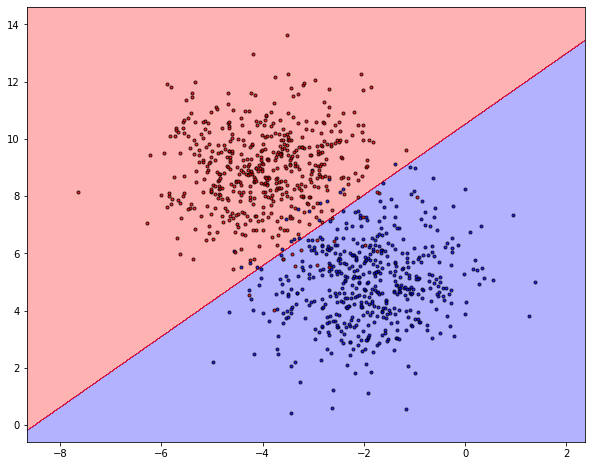

In [35]:
%%time
plot_decision_regions(X=curr_X_train, y=curr_y_train, classifier=logistic_regression_model, resolution=0.01)

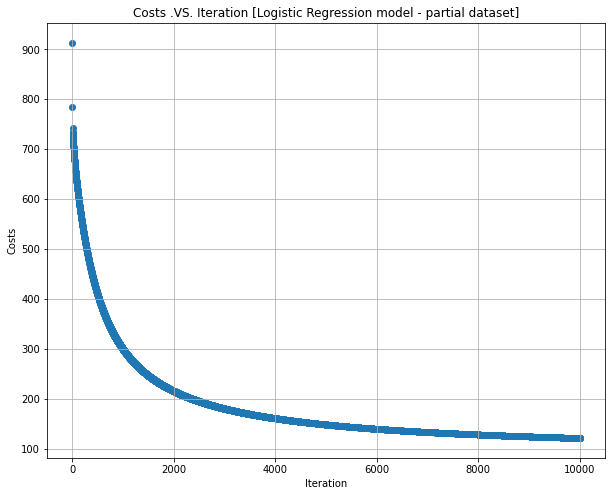

CPU times: user 220 ms, sys: 10.7 ms, total: 231 ms
Wall time: 230 ms


In [36]:
%%time
costs = logistic_regression_model.get_list_of_costs()
plt.figure()
plt.scatter(x=np.arange(len(costs)), y=costs)
plt.grid()
plt.title(f'Costs .VS. Iteration [Logistic Regression model - partial dataset]')
plt.xlabel(f'Iteration')
plt.ylabel(f'Costs')
plt.show()

##### Part 1.2: naive bayes

In [37]:
%%time
naive_bayes_model = NaiveBayesGaussian(k=3) 
naive_bayes_model.fit(curr_X_train, curr_y_train)
y_pred = naive_bayes_model.predict(curr_X_test)
accuracy_NB_subset_data = compute_accuracy(y_pred=y_pred, y_true=curr_y_test)

CPU times: user 22.6 ms, sys: 1.44 ms, total: 24.1 ms
Wall time: 22.8 ms


CPU times: user 675 ms, sys: 113 ms, total: 788 ms
Wall time: 786 ms


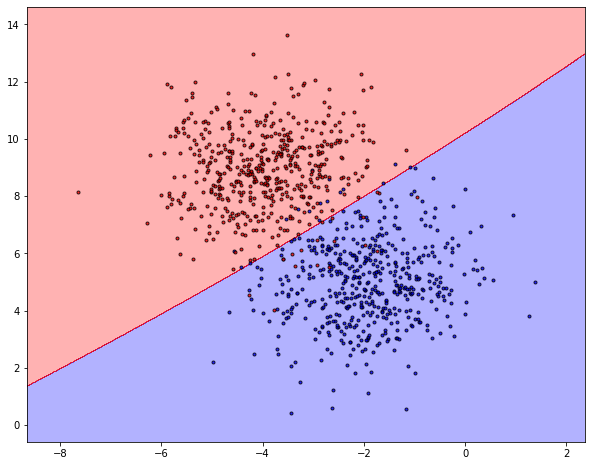

In [38]:
%%time
plot_decision_regions(X=curr_X_train, y=curr_y_train, classifier=naive_bayes_model, resolution=0.01)

#### Part 2: all training set points

##### Part 2.1: logistic regression

In [39]:
%%time
logistic_regression_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
logistic_regression_model.fit(X_training, y_training)
y_pred = logistic_regression_model.predict(X_test)
accuracy_LR_all_data = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 356 ms, sys: 2.8 ms, total: 359 ms
Wall time: 360 ms


CPU times: user 7.45 s, sys: 185 ms, total: 7.63 s
Wall time: 7.64 s


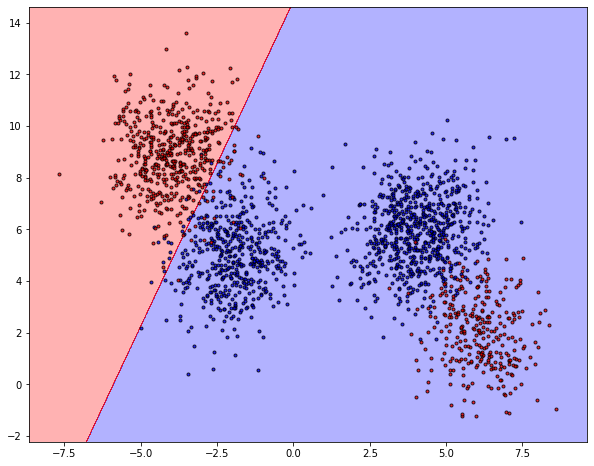

In [40]:
%%time
plot_decision_regions(X=X_training, y=y_training, classifier=logistic_regression_model, resolution=0.01)

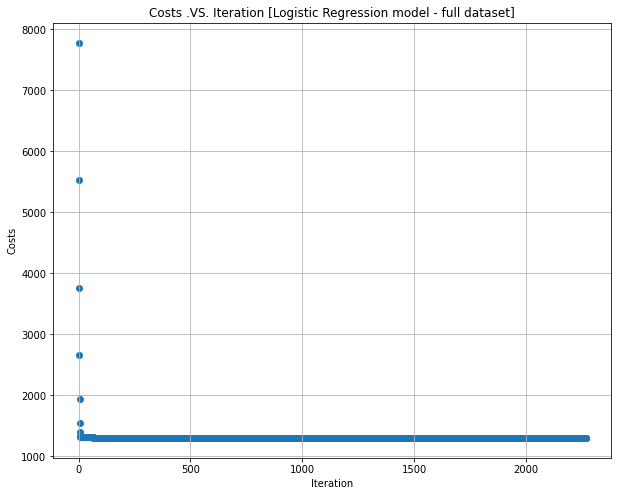

CPU times: user 228 ms, sys: 71.9 ms, total: 300 ms
Wall time: 308 ms


In [41]:
%%time
costs = logistic_regression_model.get_list_of_costs()
plt.figure()
plt.scatter(x=np.arange(len(costs)), y=costs)
plt.grid()
plt.title(f'Costs .VS. Iteration [Logistic Regression model - full dataset]')
plt.xlabel(f'Iteration')
plt.ylabel(f'Costs')
plt.show()

##### Part 2.2: naive bayes

In [42]:
%%time
naive_bayes_model = NaiveBayesGaussian(k=3) 
naive_bayes_model.fit(X_training, y_training)
y_pred = naive_bayes_model.predict(X_test)
accuracy_NB_all_data = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 43.4 ms, sys: 1.89 ms, total: 45.3 ms
Wall time: 44.7 ms


CPU times: user 1.26 s, sys: 220 ms, total: 1.48 s
Wall time: 1.48 s


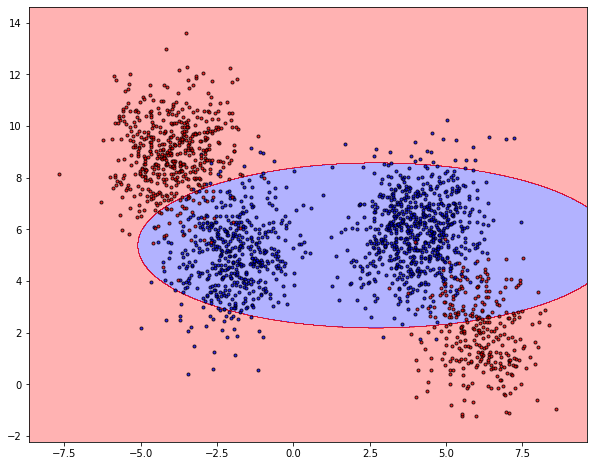

In [43]:
%%time
plot_decision_regions(X=X_training, y=y_training, classifier=naive_bayes_model, resolution=0.01)

In [44]:
print(f'Summary - accuracy results:')
print(f'Accuracy of Naive Bayes classifier on:         partial dataset  {accuracy_NB_subset_data} full dataset  {accuracy_NB_all_data}')
print(f'Accuracy of Logistic Regression classifier on: partial dataset  {accuracy_LR_subset_data} full dataset  {accuracy_LR_all_data}')

Summary - accuracy results:
Accuracy of Naive Bayes classifier on:         partial dataset  0.942 full dataset  0.873
Accuracy of Logistic Regression classifier on: partial dataset  0.938 full dataset  0.817


We can see that the NB classifier performed better in both cases - slighlty better on the subset, but much better on the full dataset.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

### Note: code will be presented first, then explanations for the chosen datasets

### Data for which Naive Bayes will work worse than Logisitc Regression

In [45]:
x_axis_values_0 = np.random.uniform(low=0.0, high=1.0, size=600)
y_axis_values_0 = np.random.uniform(low=0.0, high=1.0, size=600)
z_axis_values_0 = np.random.uniform(low=0.0, high=1.0, size=600)
labels_0 = np.zeros(600)
                          
x_axis_values_1 = np.random.uniform(low=0.6, high=1.6, size=600)
y_axis_values_1 = np.random.uniform(low=0.6, high=1.6, size=600)
z_axis_values_1 = np.random.uniform(low=0.6, high=1.6, size=600)
labels_1 = np.ones(600)

X = np.concatenate(
    [
        np.concatenate([x_axis_values_0, x_axis_values_1],axis=0).reshape(-1,1),
        np.concatenate([y_axis_values_0, y_axis_values_1],axis=0).reshape(-1,1),
        np.concatenate([z_axis_values_0, z_axis_values_1],axis=0).reshape(-1,1),
    ], 
    axis=1)
y = np.concatenate([labels_0, labels_1], axis=0)

print(f'X.shape {X.shape}, y.shape {y.shape}')

X_training = X[0:1000, :]
X_test = X[1000:, :]
y_training = y[0:1000]
y_test = y[1000:]

X.shape (1200, 3), y.shape (1200,)


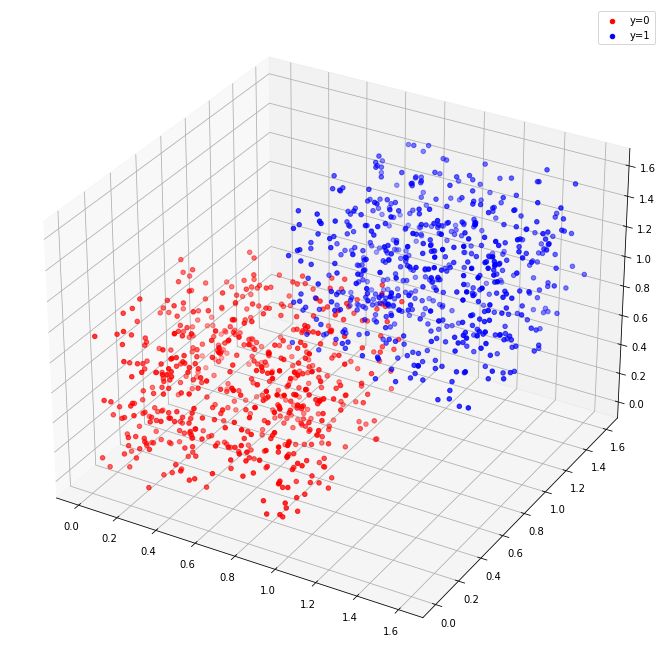

In [46]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_axis_values_0, y_axis_values_0, z_axis_values_0, color='r', label='y=0')
ax.scatter(x_axis_values_1, y_axis_values_1, z_axis_values_1, color='b', label='y=1')
plt.legend()
plt.show()

In [47]:
%%time
logistic_regression_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
logistic_regression_model.fit(X_training, y_training)
y_pred = logistic_regression_model.predict(X_test)
accuracy_LR_dataset1 = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 1.05 s, sys: 3.69 ms, total: 1.05 s
Wall time: 1.05 s


In [48]:
%%time
naive_bayes_model = NaiveBayesGaussian(k=3) 
naive_bayes_model.fit(X_training, y_training)
y_pred = naive_bayes_model.predict(X_test)
accuracy_NB_dataset1 = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 26.1 ms, sys: 1.72 ms, total: 27.8 ms
Wall time: 27 ms


### Data for which Naive Bayes will work better than Logisitc Regression

In [49]:
x_axis_values_0 = np.random.uniform(low=-0.5, high=0.5, size=600)
y_axis_values_0 = np.random.uniform(low=-0.5, high=0.5, size=600)
z_axis_values_0 = np.random.uniform(low=-0.5, high=0.5, size=600)
labels_0 = np.zeros(600)
                          
x_axis_values_1 = np.random.uniform(low=-1.5, high=1.5, size=600)
y_axis_values_1 = np.random.uniform(low=-1.5, high=1.5, size=600)
z_axis_values_1 = np.random.uniform(low=-1.5, high=1.5, size=600)
labels_1 = np.ones(600)

x_axis_values_1 = np.array([t if (-0.5 < t or t > 0.5) else t*2 for t in x_axis_values_1])
y_axis_values_1 = np.array([t if (-0.5 < t or t > 0.5) else t*2 for t in y_axis_values_1])
z_axis_values_1 = np.array([t if (-0.5 < t or t > 0.5) else t*2 for t in z_axis_values_1])

X = np.concatenate(
    [
        np.concatenate([x_axis_values_0, x_axis_values_1],axis=0).reshape(-1,1),
        np.concatenate([y_axis_values_0, y_axis_values_1],axis=0).reshape(-1,1),
        np.concatenate([z_axis_values_0, z_axis_values_1],axis=0).reshape(-1,1),
    ], 
    axis=1)
y = np.concatenate([labels_0, labels_1], axis=0)

print(f'X.shape {X.shape}, y.shape {y.shape}')

X_training = X[0:1000, :]
X_test = X[1000:, :]
y_training = y[0:1000]
y_test = y[1000:]

X.shape (1200, 3), y.shape (1200,)


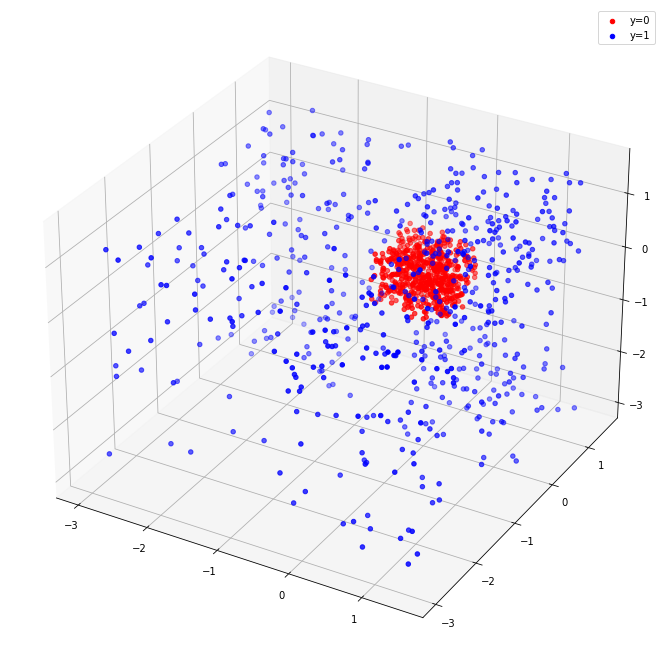

In [50]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_axis_values_0, y_axis_values_0, z_axis_values_0, color='r', label='y=0')
ax.scatter(x_axis_values_1, y_axis_values_1, z_axis_values_1, color='b', label='y=1')
plt.legend()
plt.show()

In [51]:
%%time
logistic_regression_model = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
logistic_regression_model.fit(X_training, y_training)
y_pred = logistic_regression_model.predict(X_test)
accuracy_LR_dataset2 = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 126 ms, sys: 1.83 ms, total: 128 ms
Wall time: 128 ms


In [52]:
%%time
naive_bayes_model = NaiveBayesGaussian(k=3) 
naive_bayes_model.fit(X_training, y_training)
y_pred = naive_bayes_model.predict(X_test)
accuracy_NB_dataset2 = compute_accuracy(y_pred=y_pred, y_true=y_test)

CPU times: user 27.9 ms, sys: 2.95 ms, total: 30.8 ms
Wall time: 30.5 ms


In [53]:
print(f'Summary - accuracy results:')
print(f'Accuracy of Naive Bayes classifier on:         dataset 1  {accuracy_NB_dataset1} dataset 2 {accuracy_NB_dataset2}')
print(f'Accuracy of Logistic Regression classifier on: dataset 1  {accuracy_LR_dataset1} dataset 2  {accuracy_LR_dataset2}')

Summary - accuracy results:
Accuracy of Naive Bayes classifier on:         dataset 1  0.905 dataset 2 0.835
Accuracy of Logistic Regression classifier on: dataset 1  0.955 dataset 2  0.41


#### Intuition and explanations:

* We chose 2 dataset cases: 
    1. two clusters that are slightly overlapping
    2. two clusters where ones engulfs the other
* we can see that NB performed better than logistic regression in case 2 (engulfing), and worse than logistic regression in case 1 (overlapping).
* The intuition (as derived from lectures and recitations) was that logistic regression will work better in cases that are close to being lineraly seperable, and naive bayes will work better in cases that are not quite (or not at all) linearly seperable. 
* our intuition was matched in the examples above